## 分析A/B测试结果


## 目录
- [简介](#intro)
- [I - 概率](#probability)
- [II - A/B 测试](#ab_test)
- [III - 回归](#regression)
- [IV - 测试时长](#test_time)


<a id='intro'></a>
### 简介

本项目设定了一家电子商务网站运行 A/B 测试的情境。我的目标是通过这个项目来帮助公司分析和决定他们是否应该使用新的页面，保留旧的页面，或者应该将测试时间延长，之后再做出决定。


<a id='probability'></a>
#### I - 概率

先导入数据。

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` 导入 `ab_data.csv` 数据，并将其存储在 `df` 中。

a. 导入数据集，查看前几行数据：

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. 查看数据集的行数。

In [3]:
df.shape

(294478, 5)

c. 查看数据集中的用户数量（不同的user_id数）。

In [4]:
df.user_id.nunique()

290584

d. 转化用户的占比。

In [5]:
df.converted.mean()

0.11965919355605512

e. 计算数据中 `new_page` 与 `treatment` 不匹配的次数。

- 在一个合理的实验设计里，控制组(control) 应该对应旧页面(old_page)，实验组(treatment) 对应新页面(new_page)。

In [6]:
control_mismatching = df.query('group == "control" & landing_page == "new_page"').count()[0]
treatment_mismatching = df.query('group == "treatment" & landing_page == "old_page"').count()[0]
total_mismatching = control_mismatching + treatment_mismatching
total_mismatching

3893


f. 检查是否有任何行空缺数值

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` 对于 **treatment** 和 **new_page** 不匹配的行或 **control** 与 **old_page** 不匹配的行，我们不能确定该行是接收到了新页面还是旧页面。 

a. 所以需要创建一个符合要求的新数据集，保留逻辑正确的数据，将新 dataframe 存储在 **df_matching** 中。

In [8]:
control_matching = df.query('group == "control" & landing_page == "old_page"')
treatment_matching = df.query('group == "treatment" & landing_page == "new_page"') 
df_matching = control_matching.merge(treatment_matching,how='outer')
df_matching.shape


(290585, 5)

In [9]:
# 再次确认所有不正确的行被移除掉了
df_matching[((df_matching['group'] == 'treatment') == (df_matching['landing_page'] == 'new_page')) == False].shape[0]

0

In [10]:
df_matching[((df_matching['group'] == 'control') == (df_matching['landing_page'] == 'old_page')) == False].shape[0]

0

`3.` 根据 **df_matching** 来回答以下问题。

a.  **df_matching** 中的用户数量（不同的 **user_id**) ？

In [11]:
df_matching.user_id.nunique()

290584

b.  **df_matching** 中有一个重复的 **user_id** 。它是什么？

In [12]:
df_matching[df_matching.user_id.duplicated(keep=False)].user_id

146212    773192
146678    773192
Name: user_id, dtype: int64

c. 这个重复  **user_id** 的行信息是什么？

In [13]:
df_matching.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
146212,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
146678,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. 删除一行重复行，存储 dataframe 为 **df2**。

In [14]:
df2 = df_matching.drop_duplicates('user_id')
df2.shape

(290584, 5)

`4.` 使用优化过的 **df2** 来回答以下问题。

a. 用户成功转化的整体概率是多少？（不分旧页面或者新页面）

In [15]:
df2.converted.mean()

0.11959708724499628

b. `control` 组用户的转化率是多少？

In [16]:
df_control_mean = df2[df2.group == 'control']['converted'].mean()
df_control_mean

0.1203863045004612

c. `treatment` 组用户的转化率是多少？

In [17]:
df_treatment_mean = df2[df2.group == 'treatment']['converted'].mean()
df_treatment_mean

0.11880806551510564

d. 一个用户收到新页面的概率是多少？

In [18]:
df_new_page_mean = df2[df2.landing_page == 'new_page'].count()[0]/df2.shape[0]
df_new_page_mean

0.5000619442226688

e. 分析到这里，你是否认为有足够的数据支持来证明旧页面或者新页面可以带来更高的转化率？


不能证明。因为现在的结果并没任何证据表明新页面可以带来更高的转化率。在统计上分析，新旧页面对用户转化率的影响是否具有显著性，才能给出初步的结论。

<a id='ab_test'></a>
### II - A/B 测试

因为每个事件都对应有一个时间记录（time stamp 时间戳），所以技术上你可以实现每次观察都连续运行假设检验。

然而，问题的难点在于，什么时候停止你的试验：是在发现其中一组的试验效果足够好时立即停止？还是在这样的观察结果又持续发生了一段时间再停止？需要运行多长时间才能确认两个页面没有带来用户转化率的显著差异？

这些问题是 A/B 测试中最难的部分。

`1.` 现在，根据现有的数据做出决策：除非在一类错误为5%以内的前提下新页面被证明更好，否则认定旧页面效果更佳。基于此，确定零假设和备择假设是什么？  **$p_{old}$** 与 **$p_{new}$** ，分别表示旧页面转化率与新页面转化率。


**$H{0}$** ：**$p_{new}$**  - **$p_{old}$** <= 0  

**$H{1}$** ：**$p_{new}$** -  **$p_{old}$** > 0 

`2.` 假定在零假设中，不管是新页面还是旧页面， $p_{new}$ 与 $p_{old}$ 都有相同的转化成功的概率，也就是说，  $p_{new}$ 与 $p_{old}$ 是相等的。此外，还假设它们都等于**ab_data.csv** 中的 **转化率(converted)**。  <br>

现在，在新旧页面上执行抽样分布，并计算 **转化(converted)** 差异。每个页面的样本大小与 **ab_data.csv** 相同。计算零假设中10000次迭代计算的估计值。  <br>


a. 在零假设中，$p_{new}$ **转化率** 是多少？

In [19]:
#这里我们看的是零假设，在页面转换率上不存在差别，即意味着在每个页面的转换都相同。
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. 在零假设中， $p_{old}$ **转化率** 是多少？ 

In [20]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c.  $n_{new}$ 是多少？

In [21]:
trearment_df = df2.query('group == "treatment"')
n_new = trearment_df.user_id.nunique()
n_new

145310

d.  $n_{old}$?是多少？

In [22]:
control_df = df2.query('group == "control"')
n_old = control_df.user_id.nunique()
n_old

145274

e. 在零假设中，使用 $p_{new}$ （新页面的转化率）模拟 $n_{new}$ 个新页面的转化，并将这些 $n_{new}$ 个 1 和 0 存储在 **new_page_converted** 中。

- 使用  [numpy.random.choice](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html)。

In [23]:
new_page_converted = np.random.choice([0,1], size=n_new, p=[1-p_new,p_new])
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. 在零假设中，使用 $p_{old}$ （旧页面的转化率）模拟 $n_{old}$ 个旧页面的转化，并将这些  $n_{old}$ 个 1 和 0 存储在 **old_page_converted** 中。

In [24]:
old_page_converted = np.random.choice([0,1], size=n_old, p=[1-p_old,p_old])
old_page_converted   

array([0, 1, 0, ..., 0, 0, 0])

g. 根据 e 和 f，计算 $p_{new}$ 和 $p_{old}$ 的差异值（$p_{new}$ - $p_{old}$）。

In [25]:
p_diff = new_page_converted.mean() - old_page_converted.mean()
p_diff

0.00046588202322256356

h. 由于单个数值不能形成分布图形，参考以上a-g的过程，模拟 10,000 个 $p_{new}$ 与 $p_{old}$ 差异值（$p_{new}$ - $p_{old}$），将这 10,000 个值存储在 **p_diffs** 中。

In [26]:
p_diffs = []
for _ in range(10000):
#     b_sample = df2.sample(df2.shape[0], replace=True)
#     trearment_df = b_sample.query('group == "treatment"')
#     control_df = b_sample.query('group == "control"')
#     n_new = trearment_df.user_id.nunique()
#     n_old = control_df.user_id.nunique()
    new_page_converted = np.random.choice([0,1], size=n_new, p=[1-p_new,p_new])
    old_page_converted = np.random.choice([0,1], size=n_old, p=[1-p_old,p_old])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

i. 绘制一个 **p_diffs** 分布图形。

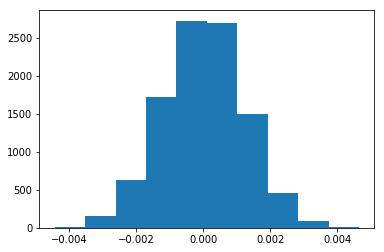

In [27]:
plt.hist(p_diffs);

j.  **p_diffs**列表的数值中，有多少比例的数值会大于 **ab_data.csv** 中观察到的实际**转化率差异** ？

In [28]:
p_diffs = np.array(p_diffs)
obs_diff = df_treatment_mean- df_control_mean
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)
(null_vals > obs_diff).mean()

0.9076

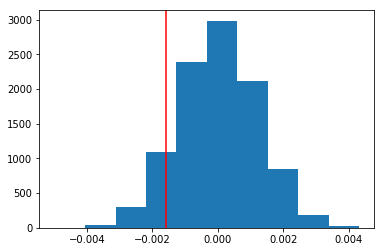

In [29]:
plt.hist(null_vals);
plt.axvline(obs_diff,color='r');

k. 用文字解释一下你刚才在 **j.** 中计算出来的结果。在数据研究中，这个值是什么？ 根据这个数值，请判断新旧页面的转化率是否有显著差异。


在数据研究中，**j.** 中计算出来的值是`P`值，这里的`P`值为0.9132，很大，说明我们无法拒绝零假设。

l. 也可以使用一个内置程序 （built-in）来实现类似的结果。使用内置程序可能很容易就能取得结果，但上面的内容仍然很重要，它可以训练正确的数据统计思维。填写下面的内容来计算每个页面的转化次数，以及收到每个页面的用户数。计算新旧页面出现的次数，也就是数据中 `n_old` 与 `n_new` 分别出现的行数。

In [30]:
import statsmodels.api as sm

convert_old = df2[df2.landing_page == 'old_page'][df2.converted == 1].count()[0]
convert_new = df2[df2.landing_page == 'new_page'][df2.converted == 1].count()[0]
n_old = df2[df2.landing_page == 'old_page'].count()[0]
n_new = df2[df2.landing_page == 'new_page'].count()[0]

d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


m. 现在使用 `stats.proportions_ztest` 来计算 z-score 与 p-value

- 什么是 [z-score](https://www.khanacademy.org/math/statistics-probability/modeling-distributions-of-data/z-scores/a/z-scores-review)
- [这里](http://knowledgetack.com/python/statsmodels/proportions_ztest/) 的资料可以提供额外信息。

In [31]:
z_score, p_value = sm.stats.proportions_ztest([convert_new,convert_old], [n_new,n_old], alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

In [32]:
from scipy.stats import norm
# Tells us how significant our z-score is
# Tells us what our critical value at 95% confidence is
norm.cdf(z_score),norm.ppf(1-0.05)

(0.09494168724097551, 1.6448536269514722)

n. 根据上题算出的 z-score 和 p-value，你认为新旧页面的转化率是否有区别？它们与 **j.** 与 **k.** 问题中的结果一致吗？



根据上题算出的 z-score 和 p-value，我认为我们无法拒绝零假设，该结果与 **j.** 和 **k.** 问题中的结果一致。

<a id='regression'></a>
### III - 回归分析法之一

`1.` 在之前的A / B测试中获得的结果也可以通过执行回归来获取。<br><br>

a. 既然每行的值是转化或不转化，那么在这种情况下，我们应该执行哪种类型的回归？


使用逻辑回归模型

b. 目标是使用 **statsmodels** 来拟合你在 **a.** 中指定的回归模型，以查看用户收到的不同页面是否存在显著的转化差异。但是，首先，你需要为这个截距创建一个列（ 原文：column） ，并为每个用户收到的页面创建一个虚拟变量列。添加一个 **截距** 列，一个 **ab_page** 列，当用户接收 **treatment** 时为1， **control** 时为0。

In [33]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,864975,2017-01-21 01:52:26.210827,control,old_page,1
3,936923,2017-01-10 15:20:49.083499,control,old_page,0
4,719014,2017-01-17 01:48:29.539573,control,old_page,0


In [34]:
df2['intercept'] = 1
df2['ab_page'] = df2.group.map({'treatment':1, 'control':0})
df2.head()

d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0
3,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0
4,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0



c. 使用 **statsmodels** 导入你的回归模型。 实例化该模型，并使用你在 **b.** 中创建的2个列来拟合该模型，用来预测一个用户是否会发生转化。

In [35]:
lm = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. 请在下方提供你的模型摘要，并根据需要使用它来回答下面的问题。

In [36]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 14 Mar 2019   Pseudo R-squ.:               8.077e-06
Time:                        22:19:03   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. 与 **ab_page** 关联的 p-值是多少？ 为什么它与你在 **II** 中发现的结果不同？<br><br> 

与 `ab_page` 关联的 p 值是0.190。它与在 II 中发现的结果（p值为0.9006）不同，原因是II 中使用的假设检验是单侧检验；而这里的回归模型中

- 零假设是：用户是否发生转换（converted）与用户收到的页面(ab_page)的相关系数为0；
- 备择假设是：用户是否发生转换（converted）与用户收到的页面(ab_page)的相关系数不为0;

所以这里使用的是双侧检验。

该结果表明 `ab_page` 的 p 值 为0.19 大于 显著性水平 0.05，无法拒绝H0。说明反应变量（用户是否发生转化）与预测变量（用户收到不同页面）的关系没有统计显著性，即新旧页面对转化率的影响没有显著差异。这与A/B测试得到的结果一致。



f. 现在，你一定在考虑其他可能影响用户是否发生转化的因素。讨论为什么考虑将其他因素添加到回归模型中是一个不错的主意。在回归模型中添加附加项有什么弊端吗？


在回归模型中考虑更多的因素能够帮助我们能更好地分析影响反应变量的因素，但是在回归模型中添加更多的因素也会带来一些问题，比如，添加的因素中存在异常点，这些点会对结果的分析造成很大影响；还可能出现添加的预测变量相互之间彼此关联，那就会出现多重共线性问题。

g. 现在，除了测试不同页面的转化率是否会发生变化之外，还要根据用户居住的国家或地区添加一个 effect 项。导入 **countries.csv** 数据集，并将数据集合并在适当的行上。 [这里](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) 是链接表格的文档。 

这个国家项对转化有影响吗？不要忘记为这些国家的列创建虚拟变量

In [37]:
df_countries = pd.read_csv('countries.csv ')
df3 = df2.merge(df_countries,on='user_id')
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US
3,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,US
4,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,US


In [38]:
df3['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [39]:
#get_dummies 返回的各列是按照字母顺序排序，因此前面的列名顺序有讲究
df3[['CA','UK','US']] = pd.get_dummies(df3.country)
df3 = df3.drop('UK',axis=1)
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,1
2,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,1
3,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,US,0,1
4,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,US,0,1


In [40]:
df3['intercept'] = 1
lm = sm.Logit(df3['converted'], df3[['intercept','ab_page','US','CA']])
results = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [41]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 14 Mar 2019   Pseudo R-squ.:               2.323e-05
Time:                        22:19:06   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9794      0.013   -155.415      0.000      -2.004      -1.954
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US            -0.0099      0.013     -0.743      0.457      -0.036       0.016
CA            -0.0506      0.028     -1.784      0.074      -0.106       0.005
==============================================================================
"""

In [42]:
1/np.exp(-0.0099),1/np.exp(-0.0506)

(1.009949167117542, 1.0519020483004984)

从模型summary中可以看出，各变量的`P`值都大于0.05的alpha通常水平，说明国家项对`converted`的影响没有统计显著性。

h. 虽然已经查看了国家与页面在转化率上的个体性因素，但现在我们要查看页面与国家/地区之间的相互作用，测试其是否会对转化产生重大影响。创建必要的附加列，并拟合一个新的模型。  

提供你的摘要结果，以及根据结果得出的结论。

**提示：页面与国家/地区的相互作用**
```
df3['new_CA'] = df3['new_page'] * df3['CA']
df3['new_UK'] = df3['new_page'] * df3['UK']
```

In [43]:
df3['new_page'] = df3.landing_page.map({'new_page':1, 'old_page':0})
df3['new_CA'] = df3['new_page'] * df3['CA']
df3['new_US'] = df3['new_page'] * df3['US']
df3.sample(5)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,US,new_page,new_CA,new_US
259240,687898,2017-01-03 00:58:40.956765,treatment,new_page,0,1,1,US,0,1,1,0,1
195002,921123,2017-01-05 00:09:06.157238,treatment,new_page,0,1,1,UK,0,0,1,0,0
172550,930012,2017-01-08 08:22:57.821264,treatment,new_page,0,1,1,US,0,1,1,0,1
37875,758552,2017-01-05 00:06:38.878305,control,old_page,0,1,0,US,0,1,0,0,0
144617,842500,2017-01-08 16:16:24.585490,control,old_page,0,1,0,UK,0,0,0,0,0


In [44]:
df3['intercept'] = 1
lm = sm.Logit(df3['converted'], df3[['intercept','CA','new_CA','new_page']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 14 Mar 2019   Pseudo R-squ.:               2.567e-05
Time:                        22:19:08   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1409
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9880      0.008   -240.457      0.000      -2.004      -1.972
CA            -0.0160      0.037     -0.429      0.668      -0.089       0.057
new_CA        -0.0552      0.053     -1.034      0.301      -0.160       0.049
new_page      -0.0123      0.012     -1.049      0.294      -0.035       0.011
==============================================================================
"""

In [45]:
1/np.exp(-0.0160),1/np.exp(-0.0552),1/np.exp(-0.0123)

(1.0161286854060947, 1.0567519439306503, 1.0123759561005452)

根据以上模型的summary结果，可以看到`new_CA`的`P`值大于0.05的通常alpha水平，说明页面与国家/地区的相互作用项对`converted`的影响没有统计显著性。

<a id='test_time'></a>
#### IV - 测试时长

In [46]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['timestamp'].max() - df['timestamp'].min()

Timedelta('21 days 23:59:49.081927')

公司针对此次的AB测试分析，只收集了21天左右的数据，实验开展得不够久，后面可以将测试时间延长。

### 总结

最后A/B测试和回归模型预测结果都表明新页面与旧页面对用户转化率的影响并没有显著差异性。
可能原因：
 - 实验时长相对较短，实验数据不够，一些老用户可能还没适应变化；
 - 也有可能实验结果就是这样的，那么就需要优化实验方案。
 
最终给该电商公司的建议是保留旧页面；或者加长实验时间后，通过分析做决定；或者重新优化新页面方案，再分析决定使用哪个页面。